<a href="https://colab.research.google.com/github/DmitryiLaptev/Tinkoff_data_analysis/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_3_(%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Логистическая регрессия и случайный лес, домашнее задание

## Обзор

В задании вам предстоит на простом примере познакомиться с базовыми инструментами построения логистической регрессии:
* визуализация
* разбиение данных на обучающую и тестовую выборки
* преобразование переменных
* отбор переменных
* $L1$ и $L2$ регуляризации
* построение итоговой модели и валидация

Далее вы построите случайный лес и сравните два класса моделей.

Все это будет на сгенерированных данных.
Примеры многих функций уже есть в коде, остальное можно посмотреть в официальных документациях или просто поискать в интернете примеры применения.

Оценка будет выставляться с учетом первых трех заданий, третье опционально

## Сгенерируем данные

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=7000, n_features=20, n_informative=5, n_redundant=2,
                           n_repeated=0, scale=None, shift=None, shuffle=False, class_sep=0.5, 
                           random_state=40)

Разбивка на train и test нужна для того, чтобы оставить часть данных нетронутой для проверки

Модель мы будем применять на данных, которые еще не видели, и разбивка позволяет нам хоть немного имитировать этот процесс

Если хотим использовать методы, требующие ручного подбора параметров (например, коэффициента регуляризации), можно выделить еще третий вид выборки — валидационную или validation. Подбор параметров традиционно выглядит так:
1. задаем параметр;
2. обучаем модель на train;
3. смотрим на качество предсказания на validation;
4. снова задаем параметр, возвращаемся к п.2;
5. ищем максимум качества на валидации;
6. выбираем параметры, которые лучше всего себя показали на validation, обучаем еще раз модель, проверяем итоги на test.

Если ручных параметров нет, можно делить выборку на 2 части — train, test

Выборка бьется последовательным применением train_test_split

Стандартные пропорции: 70:30 в случае с train/test, 60:20:20 в случае с train/val/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Можно визуализировать зависимости, посмотреть на характер данных

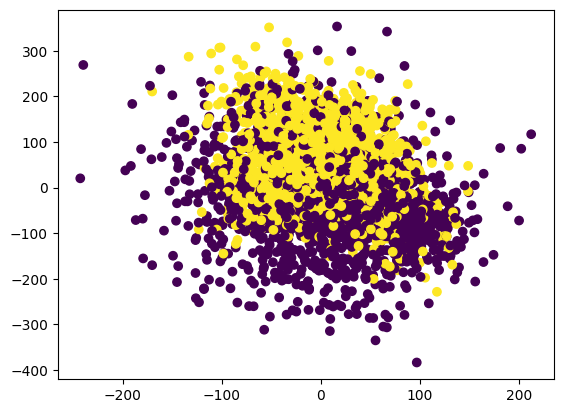

In [ ]:
plt.scatter(X_train[:, 6], X_train[:, 1], c=y_train)
plt.show()

Первично анализировать признаки удобно с помощью woe_line.

Функция делит наблюдения на группы по $X$, для каждой группы считает WoE, и откладывает эти значения на графике.

Можно встретить определение WoE, отличающееся знаком, на анализ и выводы это не влияет

# Анализ данных

## Подготовка

## Задание 1

Написать функцию woe_line:

1. разбить наблюдения на n_buckets групп по $X$
2. в каждой группе по y отложить WoE, по x медианное значение $X$
3. вывести полученный график
4. вывести ROC AUC признака (sklearn.metrics.roc_auc_score)
5. Опционально. Рассчитать доверительный интервал для bad rate (bad rate - доля наблюдений с целевой переменной =1 от всех наблюдений в группе)
6. Опционально. Нанести на график линейное приближение любым способом

График позволит проверить линейность зависимости, силу переменной, опционально проверить распределение

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [ ]:
def woe_line(X,         # 1-d array with independent feature 
             y,         # 1-d array with target feature
             n_buckets, # number of buckets to plot
             var_nm=None,    # optional, var_name to show above the plot
             target_nm=None, # optional, target_name to show above the plot
             plot_hist=None  # optional, if True — histogram of X is displayed
            ):
    allData = np.array([X,y])
    allData=allData[:,allData[0, :].argsort()]
    X=allData[0]
    y=allData[1]
    Xbuckets = np.array_split(X, n_buckets)
    ybuckets = np.array_split(y, n_buckets)
    y = np.array(y,dtype=np.uint8)
    y1all = np.sum(y==1)
    y0all = np.sum(y==0)
    y1bucket = [np.sum(y_i==1) for y_i in ybuckets]
    y0bucket = [np.sum(y_i==0) for y_i in ybuckets]
    xmax = np.max(Xbuckets, axis=1)
    xmin = np.min(Xbuckets, axis=1)
    xmedian = np.median(Xbuckets, axis=1)
    woe = -(np.log(y0bucket/y0all) - np.log(y1bucket/y1all))
    iv = woe * (y1bucket/y1all-y0bucket/y0all)
    plt.plot(xmedian, woe, "ro")
    plt.plot([xmedian,xmedian], [woe+sum(iv),woe-sum(iv)], "b_")
    print("var_nm=",var_nm)
    print("IV =",sum(iv))
    print("roc auc =",roc_auc_score(y,X))
    print("median(bad_rate) =", np.median(y0bucket/(np.array(y1bucket)+np.array(y0bucket))))
    
    #тут рисуем прямую:
    A = np.stack([xmedian, np.ones(len(xmedian))]).T
    m, c = np.linalg.lstsq(A,woe , rcond=None)[0]
    plt.plot(xmedian, xmedian*m+c, "g--",label="interpolation")
    plt.legend()
    plt.show()


    

На примере функция дополнительно отображает $R^2$ — меру линейности зависимости, а также линию, показывающую линейное приближение

## Анализ каждой переменной

var_nm= X_0
IV = 0.25188604011446375
roc auc = 0.4948359008472971
median(bad_rate) = 0.45510204081632655


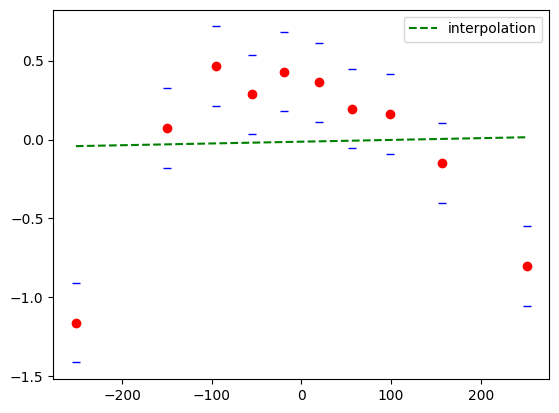

var_nm= X_1
IV = 0.8525554054439551
roc auc = 0.7432359422300613
median(bad_rate) = 0.46122448979591835


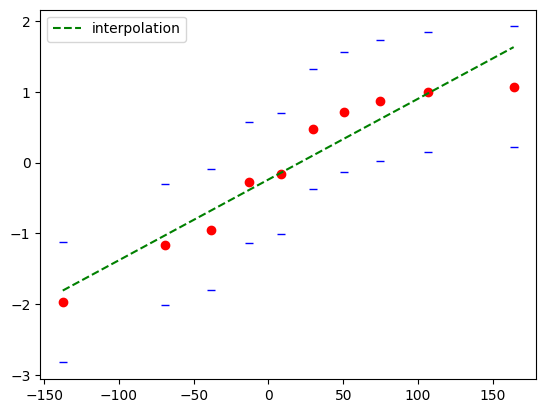

var_nm= X_2
IV = 0.7136719389993413
roc auc = 0.714388623804852
median(bad_rate) = 0.4459183673469388


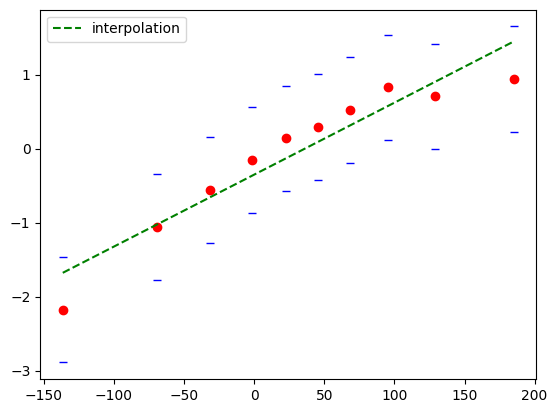

var_nm= X_3
IV = 0.14815163338144194
roc auc = 0.4036868644209686
median(bad_rate) = 0.46224489795918366


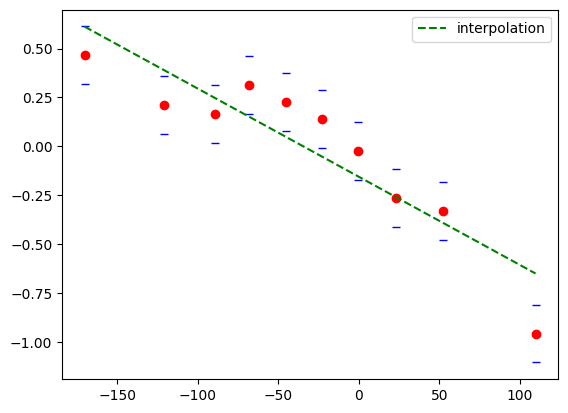

var_nm= X_4
IV = 0.1663093033534243
roc auc = 0.5013236986795
median(bad_rate) = 0.5163265306122449


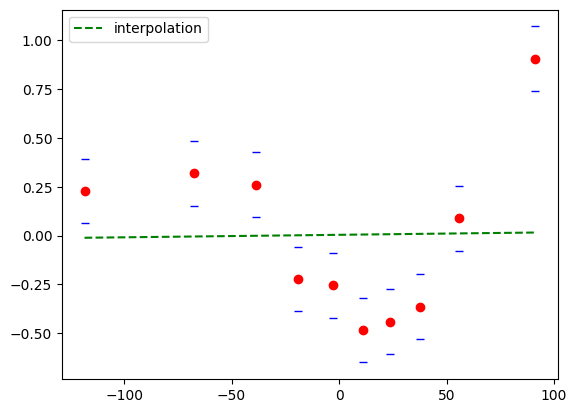

var_nm= X_5
IV = 0.13386776585733393
roc auc = 0.46624480903703613
median(bad_rate) = 0.49795918367346936


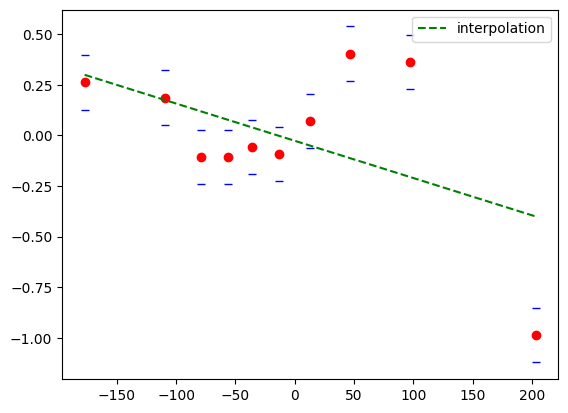

var_nm= X_6
IV = 0.2965152201227832
roc auc = 0.3868543751527489
median(bad_rate) = 0.49183673469387756


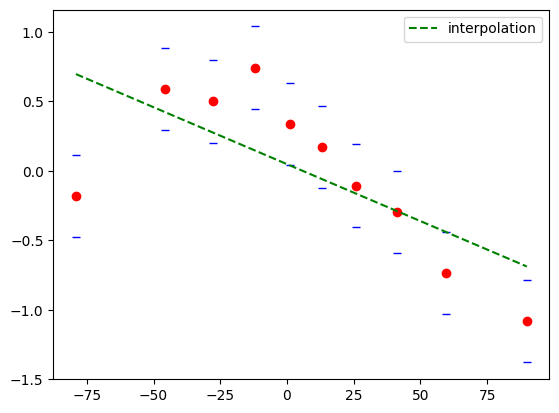

var_nm= X_7
IV = 0.006102596674879253
roc auc = 0.49272278096172945
median(bad_rate) = 0.5071428571428571


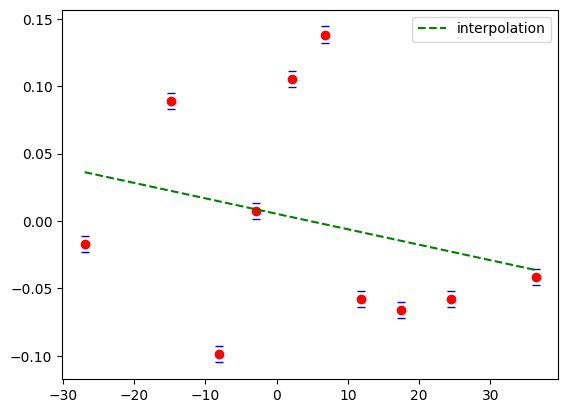

var_nm= X_8
IV = 0.011259386027067778
roc auc = 0.5079052907797237
median(bad_rate) = 0.4959183673469388


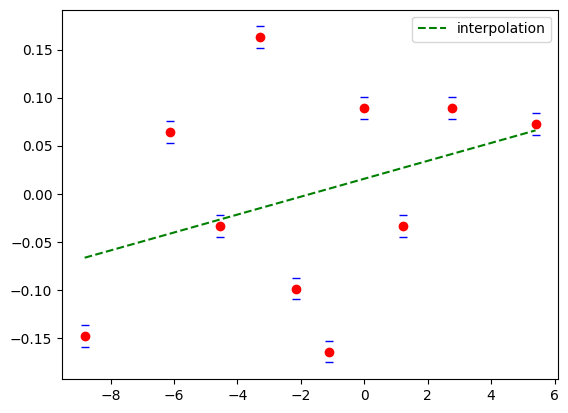

var_nm= X_9
IV = 0.006387700298212184
roc auc = 0.5036097465405658
median(bad_rate) = 0.49795918367346936


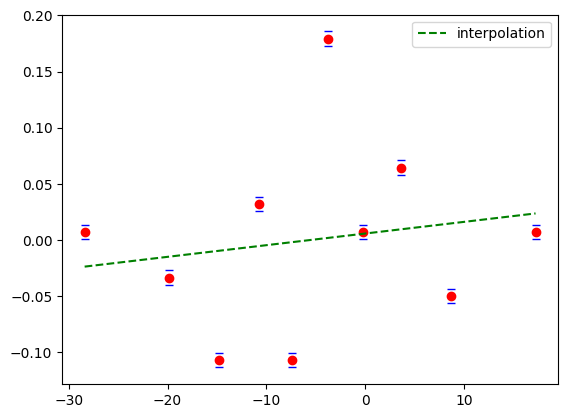

var_nm= X_10
IV = 0.003206662865133418
roc auc = 0.4963162842676025
median(bad_rate) = 0.4989795918367347


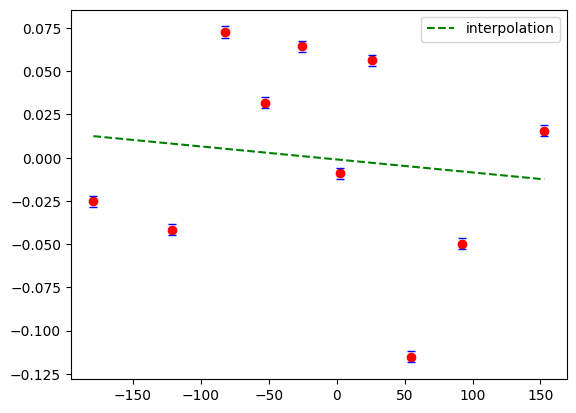

var_nm= X_11
IV = 0.011818906278285673
roc auc = 0.5056132454166173
median(bad_rate) = 0.5061224489795918


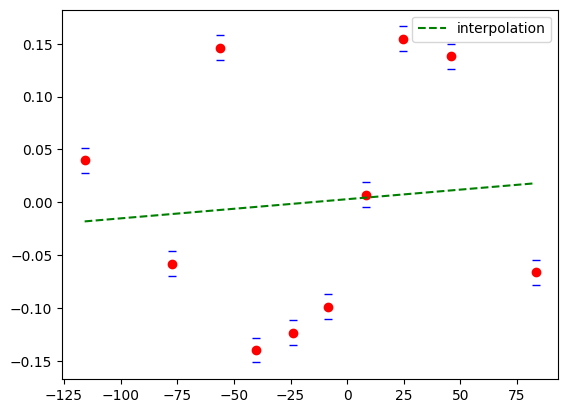

var_nm= X_12
IV = 0.00516745738848697
roc auc = 0.49474327276022867
median(bad_rate) = 0.5051020408163265


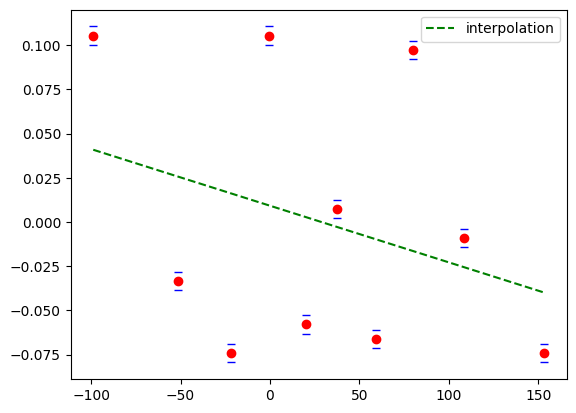

var_nm= X_13
IV = 0.006985224456915811
roc auc = 0.5017876721012365
median(bad_rate) = 0.49795918367346936


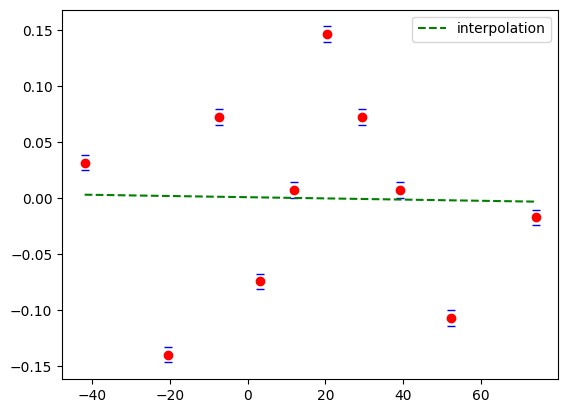

var_nm= X_14
IV = 0.009040670743034416
roc auc = 0.49151761624616674
median(bad_rate) = 0.4989795918367347


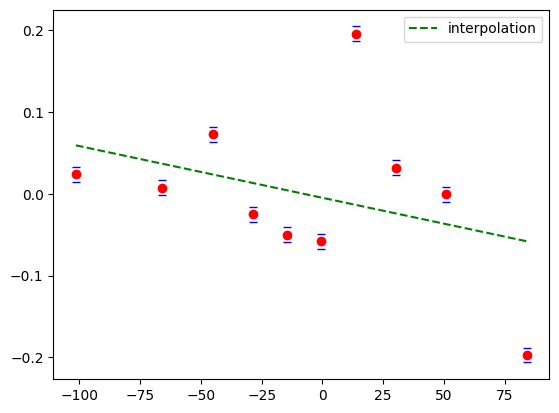

var_nm= X_15
IV = 0.010964446791752524
roc auc = 0.4929047051902883
median(bad_rate) = 0.4928571428571429


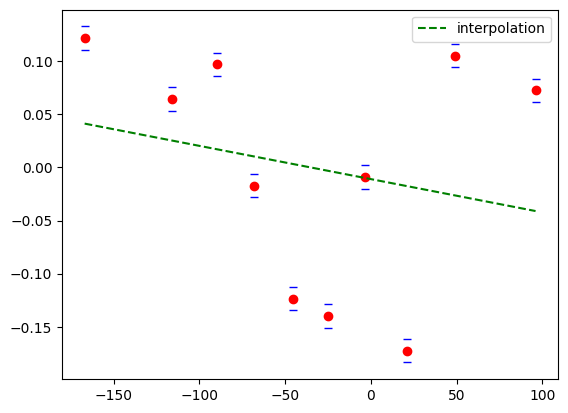

var_nm= X_16
IV = 0.0020593431336169204
roc auc = 0.5027634323637539
median(bad_rate) = 0.5


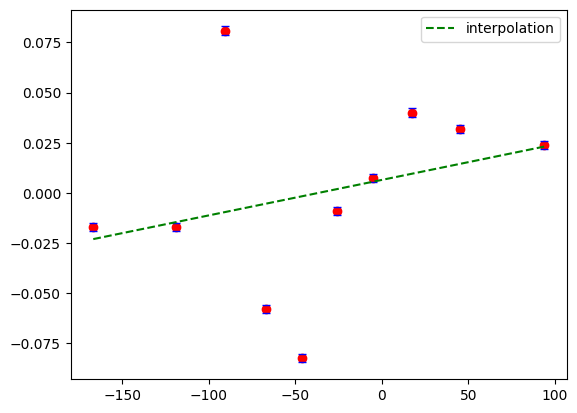

var_nm= X_17
IV = 0.014354553677369817
roc auc = 0.5033646819433039
median(bad_rate) = 0.48571428571428577


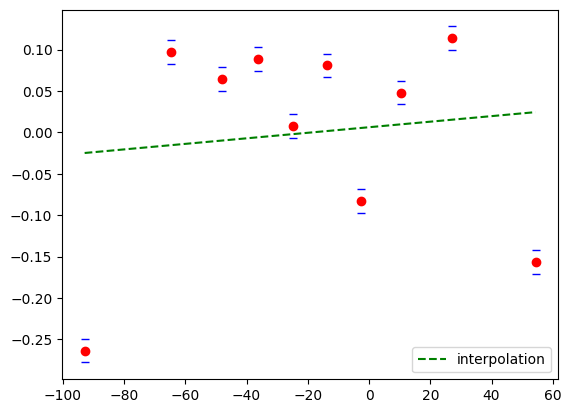

var_nm= X_18
IV = 0.006050812019789018
roc auc = 0.49733652600358613
median(bad_rate) = 0.4959183673469388


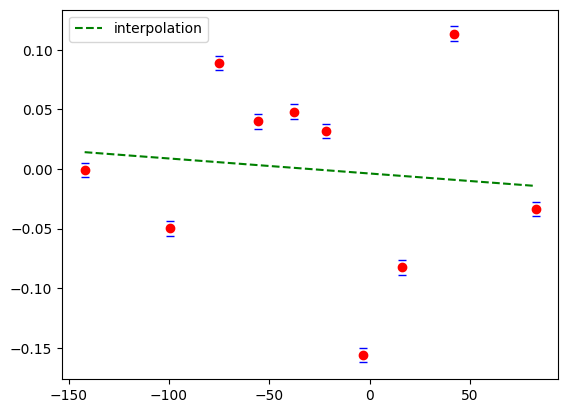

var_nm= X_19
IV = 0.0030603339394684632
roc auc = 0.5049366938670043
median(bad_rate) = 0.4969387755102041


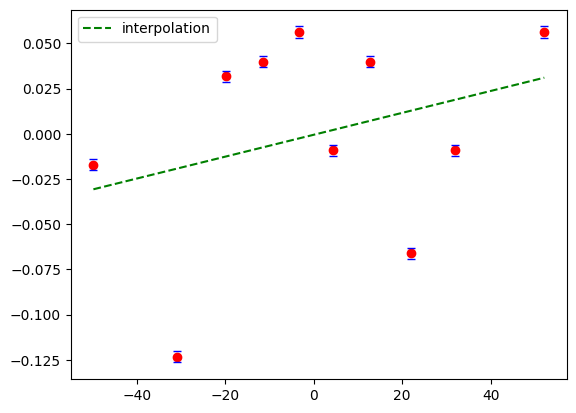

In [ ]:
for i in range(len(X_train[0])):
  woe_line(X_train[:, i], y_train, n_buckets=10,var_nm="X_"+str(i), target_nm = 'y' )
  plt.show()

В ячейке ниже пример функции и результата ее выполнения на других данных. Сам график может быть отрисован чуть иначе или в другой библиотеке, главное — сохранить суть

Видно, что переменная разделяет целевую переменную примерно до значения 0, дальше кривая выходит на плато. Можно ограничить этот хвост, чтобы не закладывать разделение в модель

Можно сразу в woe_line передавать преобразованную переменную, важно потом при проверках модели на test не забыть сделать то же преобразование

Для борьбы с выбросами можно также ограничивать длинные хвосты распределения. Особенно это полезно в реальном применении модели, чтобы ограничить влияние одной переменной на предсказание всей модели

При преобразовании переменных важно соблюдать баланс:

1. переменная должна стать линейной,
2. не стоит доводить до идеальной линейности в ущерб разделяющей силы (ROC AUC),
3. в работе с реальными данными стоит обращать внимание на физический смысл переменных. Например, в случае с размерными переменными (рубли, метры), часто помогает взятие корня или логарифма, а еще лучше приводить их к безразмерным величинам нормировкой.

## Задание 2

1. проверить каждую переменную на woe_line,
2. каждую полезную переменную линеаризовать (для каждой переменной нужны графики ДО и ПОСЛЕ),
3. ненужные переменные (слабые по ROC AUC, немонотонные) исключить из модели,
4. на отобранных и линеаризованных переменных построить модель, проверить результат на test по ROC AUC.

Подробно про обучение моделей можно почитать в официальной документации, там же есть примеры использования

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Построение логистической регрессии

In [ ]:
non_informative = []
for i in range(X_train.shape[1]):
    auc = roc_auc_score(y, X[:, i])

    if abs(auc - 0.5) < 0.025:
        print(f"{i} : {auc = :.3f} -> non_informative")
        non_informative.append(i)
    else:
        print(f"{i} : {auc = :.3f}")

0 : auc = 0.491 -> non_informative
1 : auc = 0.736
2 : auc = 0.708
3 : auc = 0.406
4 : auc = 0.502 -> non_informative
5 : auc = 0.471
6 : auc = 0.389
7 : auc = 0.490 -> non_informative
8 : auc = 0.508 -> non_informative
9 : auc = 0.507 -> non_informative
10 : auc = 0.502 -> non_informative
11 : auc = 0.501 -> non_informative
12 : auc = 0.495 -> non_informative
13 : auc = 0.500 -> non_informative
14 : auc = 0.486 -> non_informative
15 : auc = 0.504 -> non_informative
16 : auc = 0.501 -> non_informative
17 : auc = 0.514 -> non_informative
18 : auc = 0.500 -> non_informative
19 : auc = 0.502 -> non_informative


In [ ]:
# отсюда видим, что полезные переменные - 1,2,3,5,6. 123 - выглядят линейными (3 обратно линейна с минусом). 5 - немонотонна (и не особо похоже что она норм, но проделаем какие-то преобразования).
# Над 6 попробуем проделать преобразование (подошел модуль)

19 : auc = 0.470
var_nm= X_19
IV = 0.10848373931940222
roc auc = 0.47023831240954816
median(bad_rate) = 0.4806122448979592


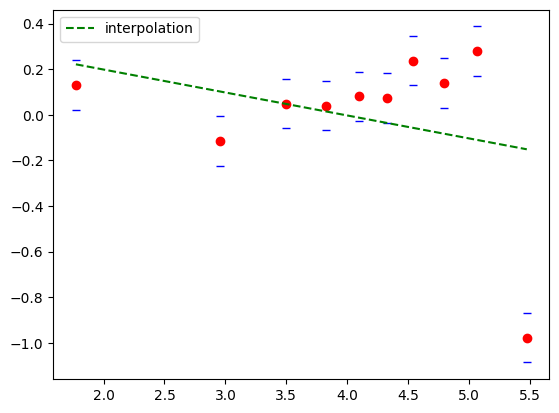

19 : auc = 0.470
var_nm= X_19
IV = 0.10848373931940222
roc auc = 0.47023831240954816
median(bad_rate) = 0.4806122448979592


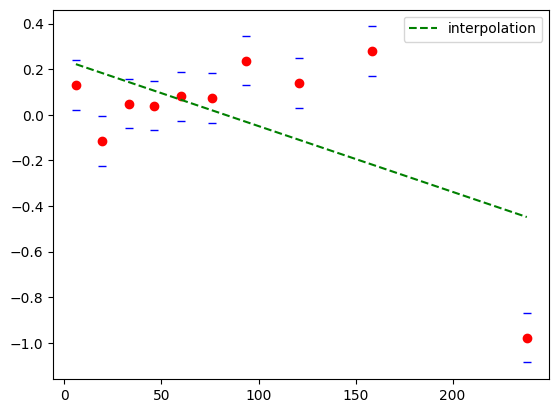

In [ ]:
tmp = (np.log(np.abs(X_train[:, 5])))
auc = roc_auc_score(y_train, tmp)
if abs(auc - 0.5) < 0.025:
    print(f"{i} : {auc = :.3f} -> non_informative")
    non_informative.append(i)
else:
    print(f"{i} : {auc = :.3f}")
woe_line(tmp, y_train, n_buckets=10,var_nm="X_"+str(i) )
tmp = (np.abs(X_train[:, 5]))
auc = roc_auc_score(y_train, tmp)
if abs(auc - 0.5) < 0.025:
    print(f"{i} : {auc = :.3f} -> non_informative")
    non_informative.append(i)
else:
    print(f"{i} : {auc = :.3f}")
woe_line(tmp, y_train, n_buckets=10,var_nm="X_"+str(i) )

19 : auc = 0.387
var_nm= X_19
IV = 0.2246996646669459
roc auc = 0.38658565374188314
median(bad_rate) = 0.47346938775510206


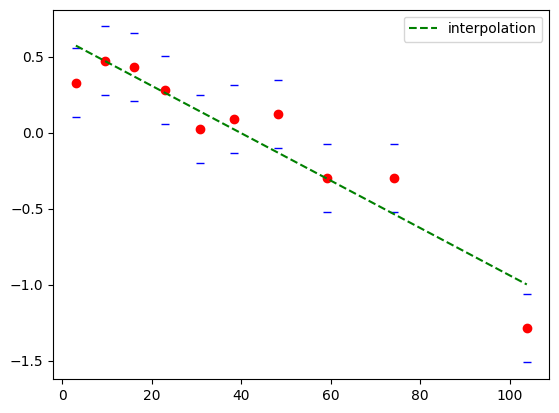

In [ ]:
tmp = (np.abs(X_train[:, 6]))
auc = roc_auc_score(y_train, tmp)
if abs(auc - 0.5) < 0.025:
    print(f"{i} : {auc = :.3f} -> non_informative")
    non_informative.append(i)
else:
    print(f"{i} : {auc = :.3f}")
woe_line(tmp, y_train, n_buckets=10,var_nm="X_"+str(i) )

In [ ]:

X_train[:,6]= np.abs(X_train[:,6])
X_test[:,6]= np.abs(X_test[:,6])
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_train[:,[1,2,3,6]], y_train)
roc_auc_score(y_test, clf.predict_proba(X_test[:,[1,2,3,6]])[:, 1])

0.8148774018924881

In [ ]:
#Добавим пятую посмотрим как это отобразится на точности предсказания
X_train[:,6]= np.abs(X_train[:,6])
X_test[:,6]= np.abs(X_test[:,6])
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_train[:,[1,2,3,5,6]], y_train)
roc_auc_score(y_test, clf.predict_proba(X_test[:,[1,2,3,5,6]])[:, 1])
# Удивительно, но скор повысился, хотя и несущественно

0.8181310228724021

## Задание 3

В этом задании предлагается сравнить алгоритм Random Forest с логистической регрессией. Обучите две модели, подобрав гиперпараметры на отделенной от трейна валидационной выборке.

 - на всех признаках из изначального датасета (на сырых данных)
 - на признаках, на которых вы строили логрег (после удаления неинформативных признаков и линеаризации остальных)

Насколько сильнее (или наоборот слабее) показали себя "деревянные модели" по сравнению с линейными? Помогла ли предобработка переменных улучшить качество случайного леса?

# Построение случайного леса

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clfR = RandomForestClassifier(max_depth=5, random_state=0)
clfR.fit(X_train[:,[1,2,3,6]], y_train)
print(roc_auc_score(y_test, clfR.predict_proba(X_test[:,[1,2,3,6]])[:, 1]))

0.854179819023569


In [ ]:
# и посмотрим что с 5:
clfR = RandomForestClassifier(max_depth=5, random_state=0)
clfR.fit(X_train[:,[1,2,3,5,6]], y_train)
print(roc_auc_score(y_test, clfR.predict_proba(X_test[:,[1,2,3,5,6]])[:, 1]))
# тут точность понизилась, но несущественно.

0.8762177268373389


In [ ]:
#Total: Случайный лес показал себя лучше на текущем наботе данных чем логистическая регрессия.
#Хотя оба результата довольно хорошие

# Дополнительно

Задание 4, опционально

В функции генерации датасета указано $n\_redundant=2$. Это значит, что две переменные получены линейной комбинацией информативных переменных.

Предыдущий анализ никак не исключает появления всех переменных в модели, для этого можно воспользоваться методами отбора признаков.

1. нужно разбить исходную выборку на 3 части: train, val, test, и попробовать подобрать коэффициент $L1$-регуляризации на валидационной выборке. Это должно убрать лишние переменные из модели и повысить таким образом ее стабильность.

Регуляризации в логистической регрессии сильно зависит от стандартного отклонения признака, поэтому стоит воспользоваться нормировкой: sklearn.preprocessing.StandardScaler

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

С нормировкой действуют те же правила: обучается она на train, применяется на val, test

2. подобрать коэффициент $L2$-регуляризации, чтобы избежать слишком больших коэффициентов и улучшить качество на val, test. На этом шаге использовать только те переменные, которые отобраны после п.1

In [ ]:
# your code here